In [1]:
import os, sys
print(sys.executable) # works this time
print(sys.version)
print(sys.version_info)

I:\mutiomics\pythonProject\.venv\Scripts\python.exe
3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
sys.version_info(major=3, minor=10, micro=11, releaselevel='final', serial=0)


In [2]:
import scanpy as sc
from sklearn.cross_decomposition import CCA
from sklearn.manifold import TSNE
from scipy.sparse import csr_matrix
from scipy.sparse import csr_matrix
import numpy as np
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import random

In [33]:
#adata1 = sc.read_h5ad("I:\\mutiomics\\MALDI_MALDI_brain_GruppeC_165x189_50umE0_data.h5ad")
adata1 = sc.read_h5ad("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\sma\\sma\\V11L12-038\\V11L12-038_D1\\output_data\\V11L12-038_D1_MSI\\V11L12-038_Mouse_D1.9aa.h5ad")
#adata2 = sc.read_h5ad("I:\\mutiomics\\10X_Visium_Ratz2022Clonal_GSM4644086_10xvisium_data.h5ad")
adata2 = sc.read_h5ad("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\sma\\sma\\V11L12-038\\V11L12-038_D1\\output_data\\V11L12-038_D1_RNA\\outs\\V11L12-038_D1.h5ad")

In [34]:
adata1.obs["leiden"] = adata1.obs["clusters"]
adata2.obs["leiden"] = adata2.obs["clusters"]
idx_to_remove = adata1.obs["clusters"][adata1.obs["clusters"] == "0"]
keep_cells_mask = ~adata1.obs.index.isin(idx_to_remove.index)
adata1 = adata1[keep_cells_mask, :]
print(adata1)
print(idx_to_remove.index)

View of AnnData object with n_obs × n_vars = 3084 × 3658
    obs: 'clusters', 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '5090', '5091', '5092', '5093', '5094', '5095', '5096', '5097', '5098',
       '5099'],
      dtype='object', length=2016)


In [38]:
data1_pca_results = adata1.obsm['spatial']  # PCA 结果
pca_leiden = adata1.obs["leiden"]
data1_leiden_str = pca_leiden.to_numpy()

data2_pca_results = adata2.obsm['X_umap']  # PCA 结果
pca_leiden = adata2.obs["leiden"]
data2_leiden_str = pca_leiden.to_numpy()


# 打印转换后的 Series 对象
print(data1_leiden_str)
def var_select(df, m1, m2, n):
    # 1. 筛选出列均值在 m1 和 m2 之间的行
    filtered_df = df.loc[:,(df.mean() > m1) & (df.mean() < m2)]

    # 2. 计算每行的方差，并选择前 n 个最大值所对应的索引
    variances = filtered_df.var(axis=0)/filtered_df.mean()
    sorted_indices = variances.sort_values(ascending=False).index
    selected_indices = sorted_indices[:n]

    return selected_indices.tolist()


def convert_to_array(x):
    if isinstance(x, csr_matrix):
        return x.toarray()
    elif isinstance(x, np.ndarray):
        return x
    else:
        raise ValueError("Unsupported input type. Must be csr_matrix or ndarray.")
        
def tpm_normalize(counts_matrix):
    # 计算每个细胞的总表达量
    total_counts_per_cell = counts_matrix.sum(axis=1)
    # 计算每个基因的 TPM
    tpm_matrix = (counts_matrix.div(total_counts_per_cell, axis=0)) * 1e4
    return tpm_matrix


['4' '4' '5' ... '4' '4' '4']


In [93]:
##############select indices
import random
selected_indices = np.random.choice(31185, 3734, replace=False)

def func1(selected_indices):
    scaler = StandardScaler()
    X_data3 = convert_to_array(adata1.X)
    X_data3 = pd.DataFrame(X_data3)
    X_data3 = scaler.fit_transform(X_data3)
    X_data3 = pd.DataFrame(X_data3)
    high_variance_variables = var_select(X_data3,-10,400, 500)
    X_data3 = X_data3.iloc[:,high_variance_variables]
    pca = PCA()
    # 对数据进行 PCA
    X3_pca = pca.fit_transform(X_data3)
    umap_model = umap.UMAP(n_components=2, random_state=42)
    X_3_umap_results = umap_model.fit_transform(X3_pca)
    #X3_tsne = TSNE(n_components=3,perplexity=10, random_state=42).fit_transform(X3_pca[:,0:30])

    X_1_umap_results = X_3_umap_results[selected_indices,:]
    #X1_tsne = TSNE(n_components=3,perplexity=10, random_state=42).fit_transform(X1_pca[:,0:30])


    X_data2 = convert_to_array(adata2.X)
    X_data2 = pd.DataFrame(X_data2)
    X_data2 = tpm_normalize(X_data2)
    X_data2 = np.log2(X_data2 + 1)
    X_data2 = pd.DataFrame(X_data2)
    high_variance_variables = var_select(X_data2,0.01,40 ,2000)
    X_data2 = X_data2.iloc[:,high_variance_variables]
    #X_data2 = scaler.fit_transform(X_data2)
    pca = PCA()
    # 对数据进行 PCA
    X2_pca = pca.fit_transform(X_data2)
    umap_model = umap.UMAP(n_components=2, random_state=42)
    X_2_umap_results = umap_model.fit_transform(X2_pca[:, 0:30])
    cca = CCA(n_components=2)
    cca.fit(X_1_umap_results,X_2_umap_results)
    X_c = cca.transform(X_1_umap_results)
    Y_c = cca.transform(X_2_umap_results)
    Z_c = cca.transform(X_3_umap_results)

    X_c=pd.DataFrame(X_c)
    Y_c=pd.DataFrame(Y_c)
    Z_c=pd.DataFrame(Z_c)

    dist_min = 0.1 ## min euclidean distance
    from scipy.spatial.distance import cdist
    distances = cdist(Z_c, Y_c, metric='euclidean')
    dist_df = pd.DataFrame(distances)
    dt_describe = dist_df.describe()
    ###############找出Y_C(spatial)周围dist_min以内的Z_C(metabolic)点
    row_indices, col_indices = np.where(distances <dist_min)
    unique_row_indices = np.unique(row_indices)
    return unique_row_indices

def sample_and_apply(input_array, n):
    output_array = []
    elements = list(input_array)  # 生成包含所有元素的列表
    
    while elements:  # 当列表不为空时循环
        random.shuffle(elements)  # 随机洗牌
        sample = elements[:n]  # 从列表中随机抽取 n 个元素
        output_array.append(func1(sample))  # 将输出值存储在新数组中
        elements = elements[n:]  # 更新列表，移除已经抽取过的元素
    
    return output_array
output_array = sample_and_apply(range(29872), 3734)
print("select indice finished")

I:\mutiomics\pythonProject\.venv\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
I:\mutiomics\pythonProject\.venv\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
I:\mutiomics\pythonProject\.venv\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
I:\mutiomics\pythonProject\.venv\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


select indice finished


In [221]:
print(len(output_array))
array_lengths = [len(arr) for arr in output_array]

# 打印每个数组的长度
for i, length in enumerate(array_lengths):
    print("Length of array", i+1, ":", length)
merged_array = np.concatenate(output_array)
merged_array = np.unique(merged_array)
print(len(merged_array))
np.random.choice(merged_array, 3735, replace=False)

8
Length of array 1 : 4650
Length of array 2 : 4713
Length of array 3 : 4636
Length of array 4 : 4631
Length of array 5 : 4628
Length of array 6 : 4663
Length of array 7 : 4652
Length of array 8 : 4578
4765


array([15593, 22645,  4588, ...,  3432,   954, 25880], dtype=int64)

In [6]:
selected_indices = np.random.choice(31185, 3734, replace=False)
selected_indices = np.random.choice(3084, 2220, replace=False)
X1_label=adata1.obs["leiden"].to_numpy()[selected_indices].astype(int)
X1_label[np.isin(X1_label, [1, 4])] = 12
X1_label[X1_label == 0] = 13
X1_label[X1_label == 8] = 14
# 将除了12和13之外的所有值都替换为100
X1_label[~np.isin(X1_label, [12, 13,14])] = 15
print(X1_label)
X3_label = adata1.obs["leiden"].to_numpy().astype(int)
X3_label[np.isin(X3_label, [1, 4])] = 12
X3_label[X3_label == 0] = 13
X3_label[X3_label == 8] = 14
# 将除了12和13之外的所有值都替换为100
X3_label[~np.isin(X3_label, [12, 13,14])] = 15

X2_label = adata2.obs["leiden"].to_numpy().astype(int)
X2_label[X2_label == 0] = 12
X2_label[X2_label == 7] = 14
X2_label[np.isin(X2_label, [1, 4,5, 6,8])] = 13

# 将除了12和13之外的所有值都替换为100
X2_label[~np.isin(X2_label, [12, 13,14])] = 15



[13 13 13 ... 15 15 13]


In [39]:
selected_indices = np.random.choice(31185, 3734, replace=False)
selected_indices = np.random.choice(3084, 2220, replace=False)
X1_label=adata1.obs["leiden"].to_numpy()[selected_indices].astype(int)
X1_label[X1_label == 2] = 10
X1_label[X1_label == 3] = 11
# 将除了12和13之外的所有值都替换为100
X1_label[~np.isin(X1_label, [10,11])] = 12
print(X1_label)
X3_label = adata1.obs["leiden"].to_numpy().astype(int)
X3_label[X3_label == 2] = 10
X3_label[X3_label == 3] = 11
# 将除了12和13之外的所有值都替换为100
X3_label[~np.isin(X3_label, [10,11])] = 12

X2_label = adata2.obs["leiden"].to_numpy().astype(int)
X2_label[X2_label == 0] = 10
X2_label[X2_label == 1] = 11
# 将除了12和13之外的所有值都替换为100
X2_label[~np.isin(X2_label, [10,11])] = 12

[12 11 11 ... 10 12 11]


In [7]:
X1_label = adata1.obs["leiden"].to_numpy()[selected_indices].astype(int)
X3_label = adata1.obs["leiden"].to_numpy().astype(int)
X2_label = adata2.obs["leiden"].to_numpy().astype(int)

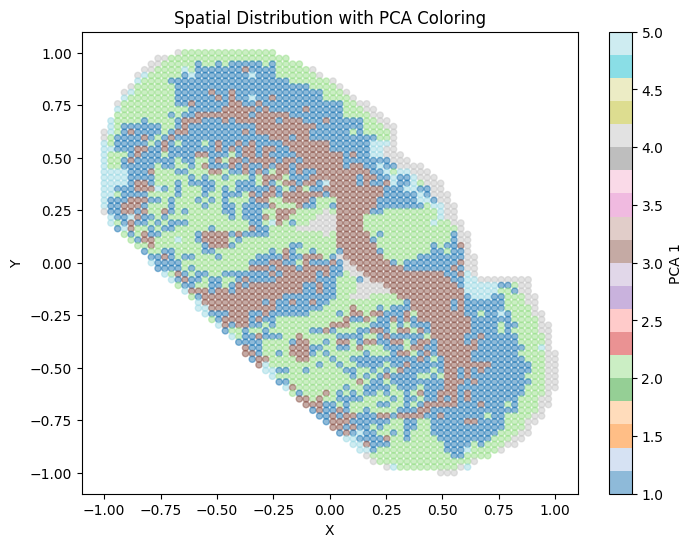

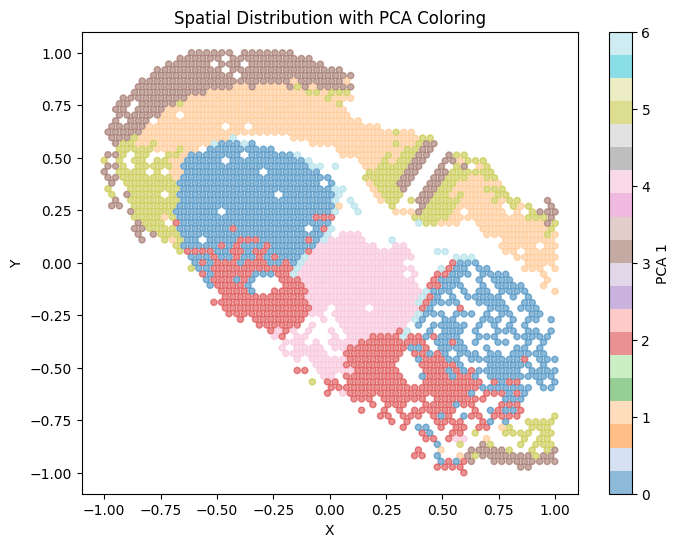

In [96]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(data3_spatial_results.iloc[:, 0], data3_spatial_results.iloc[:, 1], c=data1_leiden_str.astype(int), cmap='tab20', s=20, alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()
plt.figure(figsize=(8, 6))
plt.scatter(data2_spatial_results.iloc[:, 0], data2_spatial_results.iloc[:, 1], c=data2_leiden_str.astype(int), cmap='tab20', s=20, alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()


In [93]:
#####spatial alignment of data3(metabolic) and data2(spatial) using CCA
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))

data3_spatial_results = pd.DataFrame(adata1.obsm['spatial'])
scaled_data = scaler.fit_transform(data3_spatial_results)
data3_spatial_results = pd.DataFrame(scaled_data, columns=data3_spatial_results.columns)
print(data3_spatial_results.head)
data1_spatial_results = data3_spatial_results.iloc[selected_indices,:]
data2_spatial_results = pd.DataFrame(adata2.obsm['spatial'])
scaled_data = scaler.fit_transform(data2_spatial_results)
data2_spatial_results = pd.DataFrame(scaled_data, columns=data3_spatial_results.columns)
print(data1_spatial_results.head)

cca = CCA(n_components=2)
cca.fit(data1_spatial_results,data2_spatial_results)
#data1_spatial_results = cca.transform(data1_spatial_results)
#data2_spatial_results = cca.transform(data2_spatial_results)
#data3_spatial_results = cca.transform(data3_spatial_results)
data1_spatial_results=pd.DataFrame(data1_spatial_results)
data2_spatial_results=pd.DataFrame(data2_spatial_results)
data3_spatial_results=pd.DataFrame(data3_spatial_results)

<bound method NDFrame.head of         0         1
0    -1.0 -0.621622
1    -1.0 -0.594595
2    -1.0 -0.567568
3    -1.0 -0.540541
4    -1.0 -0.513514
...   ...       ...
3079  1.0  0.486486
3080  1.0  0.513514
3081  1.0  0.540541
3082  1.0  0.567568
3083  1.0  0.594595

[3084 rows x 2 columns]>
<bound method NDFrame.head of              0         1
126  -0.850746 -0.486486
2628  0.552239  0.324324
1352 -0.104478  0.054054
109  -0.880597 -0.135135
1105 -0.223881 -0.297297
...        ...       ...
2359  0.402985 -0.081081
1442 -0.044776 -0.756757
1984  0.194030  0.675676
277  -0.731343 -0.216216
2637  0.552239  0.567568

[2220 rows x 2 columns]>


In [94]:
def rotate_point_90_degrees(row):
    new_x = -row[0]
    new_y = row[1]
    return pd.Series({0: new_x, 1: new_y})
data3_spatial_results = data3_spatial_results.apply(rotate_point_90_degrees, axis=1)

In [95]:
def flip_around_y_minus_x(row):
    new_x = -row[0]
    new_y = -row[1]
    return pd.Series({0: new_x, 1: new_y})
data3_spatial_results = data3_spatial_results.apply(flip_around_y_minus_x, axis=1)

In [97]:
#####X1:metabolic subgroup 
#####X2:spatial 
#####X3:metabolic whole group
#####normalize, pca and umap of X1,X2 and X3
#####perform CCA between X1 and X2
#####fit CCA model to X1 X2 X3



pca_leiden = adata1.obs["leiden"]
data1_leiden_str = pca_leiden.to_numpy()
pca_leiden = adata2.obs["leiden"]
data2_leiden_str = pca_leiden.to_numpy()
scaler = MinMaxScaler(feature_range=(-1, 1))

#print(X_1_umap_results.head)
print(pd.DataFrame(adata1.obsm['spatial']).iloc[selected_indices,0])
X_data3 = convert_to_array(adata1.X)
X_data3 = pd.DataFrame(X_data3)
X_data3 = scaler.fit_transform(X_data3)
X_data3 = pd.DataFrame(X_data3)
high_variance_variables = var_select(X_data3,-100,40000, 500)
X_data3 = X_data3.iloc[:,high_variance_variables]
pca = PCA()
# 对数据进行 PCA
X3_pca = pca.fit_transform(X_data3)
umap_model = umap.UMAP(n_components=2, random_state=42)
X_3_umap_results = pd.DataFrame(umap_model.fit_transform(X3_pca))
scaled_data = scaler.fit_transform(X_3_umap_results)
X_3_umap_results = pd.DataFrame(scaled_data, columns=X_3_umap_results.columns)
X_3_umap_results[2] = X3_label
X_3_umap_results[3] = pd.DataFrame(data3_spatial_results).iloc[:,0].to_numpy()
X_3_umap_results[4] = pd.DataFrame(data3_spatial_results).iloc[:,1].to_numpy()
#X3_tsne = TSNE(n_components=3,perplexity=10, random_state=42).fit_transform(X3_pca[:,0:30])

X_1_umap_results = X_3_umap_results.iloc[selected_indices,]


X_data2 = convert_to_array(adata2.X)
X_data2 = pd.DataFrame(X_data2)
X_data2 = tpm_normalize(X_data2)
X_data2 = np.log2(X_data2 + 1)
X_data2 = pd.DataFrame(X_data2)
high_variance_variables = var_select(X_data2,0.01,40 ,2000)
X_data2 = X_data2.iloc[:,high_variance_variables]
#X_data2 = scaler.fit_transform(X_data2)
pca = PCA()
# 对数据进行 PCA
X2_pca = pca.fit_transform(X_data2)
umap_model = umap.UMAP(n_components=2, random_state=42)
X_2_umap_results = pd.DataFrame(umap_model.fit_transform(X2_pca[:, 0:30]))
scaled_data = scaler.fit_transform(X_2_umap_results)
X_2_umap_results = pd.DataFrame(scaled_data, columns=X_2_umap_results.columns)
#X2_tsne = TSNE(n_components=3,perplexity=10, random_state=42).fit_transform(X2_pca[:,0:30])
X_2_umap_results[2] = X2_label
X_2_umap_results[3] = pd.DataFrame(data2_spatial_results).iloc[:,0].to_numpy()
X_2_umap_results[4] = pd.DataFrame(data2_spatial_results).iloc[:,1].to_numpy()
cca = CCA(n_components=2)
cca.fit(X_1_umap_results,X_2_umap_results)
X_c = cca.transform(X_1_umap_results)
Y_c = cca.transform(X_2_umap_results)
Z_c = cca.transform(X_3_umap_results)

X_c=pd.DataFrame(X_c)
Y_c=pd.DataFrame(Y_c)
Z_c=pd.DataFrame(Z_c)

126      5
2628    52
1352    30
109      4
1105    26
        ..
2359    47
1442    32
1984    40
277      9
2637    52
Name: 0, Length: 2220, dtype: int64


I:\mutiomics\pythonProject\.venv\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
I:\mutiomics\pythonProject\.venv\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


I:\mutiomics\pythonProject\.venv\lib\site-packages\matplotlib\collections.py:1109: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(2220, 2)


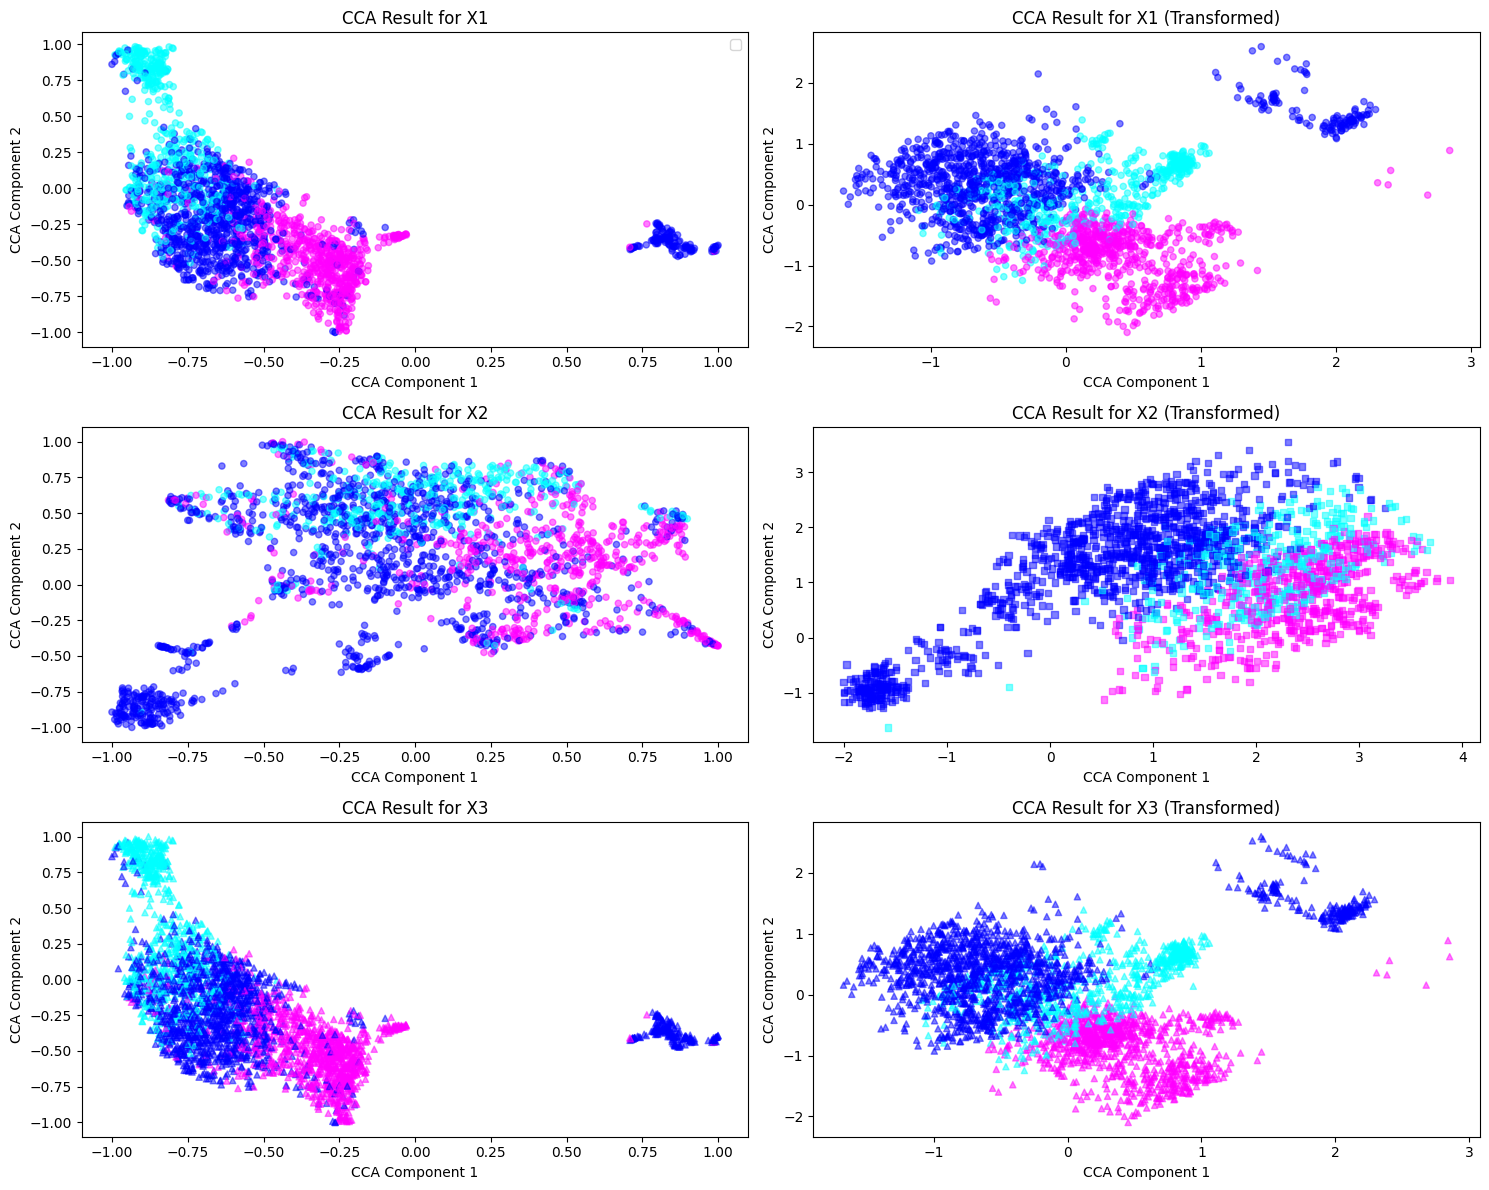

In [98]:
print(X_c.shape)
import matplotlib.pyplot as plt


#X2_tsne = TSNE(n_components=3,perplexity=10, random_state=42).fit_transform(X2_pca[:,0:30])
color_mapping = {
    0: 'blue',
    1: 'red',
    2: 'green',
    3: 'yellow',
    4: 'orange',
    5: 'purple',
    6: 'brown',
    7: 'pink',
    8: 'gray',
    9: 'cyan',
    10: 'magenta',
    11: 'cyan',
    12: 'blue',
    13: 'red',
    14: 'green',
    15: 'yellow'
}

# 假设 X_c 和 Y_c 是 CCA 转换后的结果
# 在这个示例中，假设 X_c 和 Y_c 都是二维数据

plt.figure(figsize=(15, 12))

# 绘制 X1 的散点图
plt.subplot(3, 2, 1)
scatter = plt.scatter(X_1_umap_results.iloc[:, 0], X_1_umap_results.iloc[:, 1],
                     # c=[color_mapping[category] for category in data1_leiden_str[selected_indices].astype(int)],
                      c=[color_mapping[category] for category in X1_label],
                      s=20, alpha=0.5)
unique_categories = np.unique(data1_leiden_str[selected_indices].astype(int))
legend_labels = [f'Category {cat}' for cat in unique_categories]
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels)
plt.title('CCA Result for X1')
plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')


# 绘制 X1 转换后的散点图
plt.subplot(3, 2, 2)
plt.scatter(X_c.iloc[:, 0], X_c.iloc[:, 1], 
          #  c= [color_mapping[category] for category in data1_leiden_str[selected_indices].astype(int)], 
            c= [color_mapping[category] for category in X1_label],
            s=20, alpha=0.5)
plt.title('CCA Result for X1 (Transformed)')
plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')

# 绘制 X2 的散点图
plt.subplot(3, 2, 3)
plt.scatter(X_2_umap_results.iloc[:, 0], X_2_umap_results.iloc[:, 1], 
           # c=[color_mapping[category] for category in data2_leiden_str.astype(int)],
            c= [color_mapping[category] for category in X2_label],
            s=20, alpha=0.5)
plt.title('CCA Result for X2')
plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')

# 绘制 X2 转换后的散点图
plt.subplot(3, 2, 4)
plt.scatter(Y_c.iloc[:, 0], Y_c.iloc[:, 1], 
          #  c=[color_mapping[category] for category in data2_leiden_str.astype(int)], 
             c= [color_mapping[category] for category in X2_label],
            s=20, alpha=0.5, marker='s')
plt.title('CCA Result for X2 (Transformed)')
plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')

# 绘制 X3 的散点图
plt.subplot(3, 2, 5)
plt.scatter(X_3_umap_results.iloc[:, 0], X_3_umap_results.iloc[:, 1], 
           # c=[color_mapping[category] for category in data1_leiden_str.astype(int)],
             c= [color_mapping[category] for category in X3_label],
            s=20, alpha=0.5, marker='^')
plt.title('CCA Result for X3')
plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')

# 绘制 X3 转换后的散点图
plt.subplot(3, 2, 6)
plt.scatter(Z_c.iloc[:, 0], Z_c.iloc[:, 1], 
          #  c=[color_mapping[category] for category in data1_leiden_str.astype(int)] , 
             c= [color_mapping[category] for category in X3_label],
            s=20, alpha=0.5, marker='^')
plt.title('CCA Result for X3 (Transformed)')
plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')

plt.tight_layout()
plt.show()

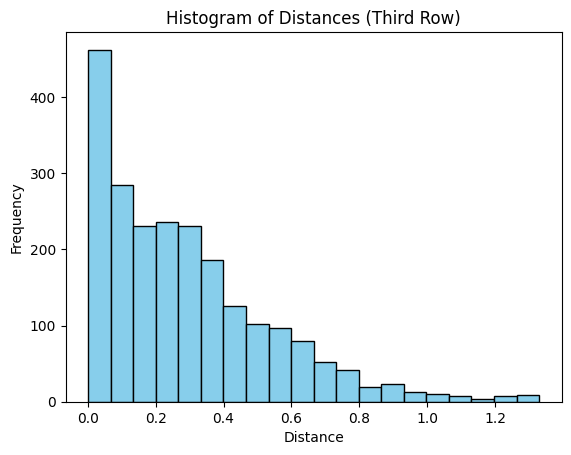

C:\Users\28123\AppData\Local\Temp\ipykernel_2216\3361970095.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_C_['spatial_ID'] = Y_C_.index
C:\Users\28123\AppData\Local\Temp\ipykernel_2216\3361970095.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z_C_['matabolic_ID'] = Z_C_.index
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(182968,) (182968,)
(3038,)
(1954,)
           0         1
9   1.387888  2.012911
13  1.118710  2.808185
14  1.265248  2.635141
41  1.731413  2.891996
80  1.318619  2.320293
          0         1
0  1.459259  2.558087
0  1.459259  2.558087
0  1.459259  2.558087
0  1.459259  2.558087
0  1.459259  2.558087
   spatial.CCA.X  spatial.CCA.Y  spatial_ID  spatial_cluster  spatial.CCA.Z
0       1.387888       2.012911           9                5             -1
1       1.118710       2.808185          13                3             -1
2       1.265248       2.635141          14                3             -1
3       1.731413       2.891996          41                3             -1
4       1.318619       2.320293          80                3             -1
   metabolic.CCA.X  metabolic.CCA.Y  matabolic_ID  matabolic_cluster  \
0         1.459259         2.558087             0                  4   
1         1.459259         2.558087             0                  4   
2         1.459259    

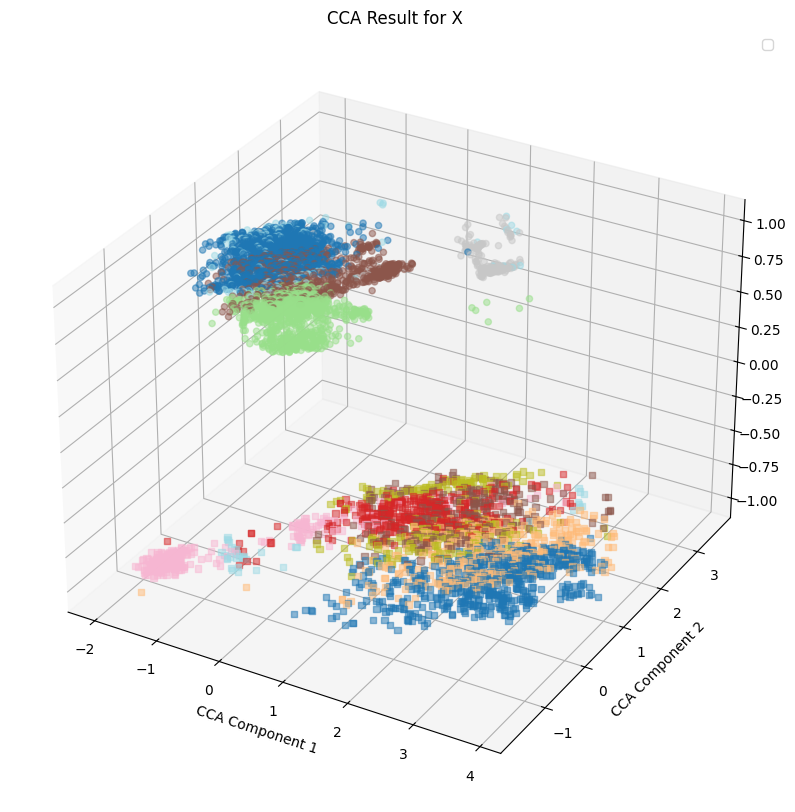

In [99]:
####select nearst neighbour of sample pairs between X1 and X3
####
dist_min = 0.6 ## min euclidean distance
from scipy.spatial.distance import cdist
distances = cdist(Z_c, Y_c, metric='euclidean')
dist_df = pd.DataFrame(distances)
dt_describe = dist_df.describe()
plt.hist(dt_describe.iloc[3,], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Distances (Third Row)')
plt.show()
###############找出Y_C(spatial)周围dist_min以内的Z_C(metabolic)点
row_indices, col_indices = np.where(distances <dist_min)
unique_row_indices = np.unique(row_indices)
unique_col_indices = np.unique(col_indices)
#############plot
####Z_C is metablic and is at 1
print(row_indices.shape, col_indices.shape)
print(unique_row_indices.shape)
print(unique_col_indices.shape)
print(Y_c.iloc[col_indices,].head())
print(Z_c.iloc[row_indices,].head())
Y_C_=Y_c.iloc[col_indices,]
Y_C_['spatial_ID'] = Y_C_.index
Y_C_=Y_C_.reset_index()
Y_C_["spatial_cluster"] = data2_leiden_str[col_indices].astype(int)
Y_C_["spatial.CCA.Z"] = -1
Y_C_=Y_C_.drop(columns=['index'])
Y_C_=Y_C_.rename(columns={0: "spatial.CCA.X", 1:"spatial.CCA.Y"})

Z_C_=Z_c.iloc[row_indices,]
Z_C_['matabolic_ID'] = Z_C_.index
Z_C_=Z_C_.reset_index()
Z_C_["matabolic_cluster"] = data1_leiden_str[row_indices].astype(int)
Z_C_=Z_C_.drop(columns=['index'])
Z_C_["matabolic.CCA.Z"] = 1
Z_C_=Z_C_.rename(columns={0: "metabolic.CCA.X", 1:"metabolic.CCA.Y"})

print(Y_C_.head())
print(Z_C_.head())
pairs = pd.concat([Y_C_,Z_C_],axis=1)
#pairs["distance"] = dist_df.iloc[row_indices,col_indices].values.diagonal()  //diagonal要求内存过大
print(pairs.head())

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
plt.scatter(Z_c.iloc[unique_row_indices, 0], Z_c.iloc[unique_row_indices, 1],zs=1, c=data1_leiden_str[unique_row_indices].astype(int), cmap='tab20', s=20, alpha=0.5)
plt.scatter(Y_c.iloc[:, 0], Y_c.iloc[:, 1],zs=-1, c=data2_leiden_str.astype(int), cmap='tab20', s=20, alpha=0.5,marker='s')
#for i in range(0,pairs.shape[0]):
#    plt.plot(pairs.iloc[i,[0,5]], pairs.iloc[i,[1,6]], pairs.iloc[i,[4,9]], 'gray', linewidth=0.2)
plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')
plt.title('CCA Result for X')
plt.legend()
plt.show()


In [100]:
import pandas as pd

def calculate_simpson_index(values):
    total_count = len(values)
    unique_values = set(values)
    simpson_index = 1 - sum((values.count(value) / total_count) ** 2 for value in unique_values)
    return simpson_index

def main(df):
    # 保存每个 X1 中值对应的 X2 中值的列表
    x1_x2_lists = df.groupby('spatial_ID')['matabolic_cluster'].apply(list).reset_index()

    # 计算每个 X1 中值的辛普森指数
    simpson_indices = x1_x2_lists['matabolic_cluster'].apply(calculate_simpson_index)

    # 保存每个 X1 中值对应的 X2 中出现频率最高的值
    max_x2_values = x1_x2_lists['matabolic_cluster'].apply(lambda x: max(set(x), key=x.count))

    # 生成新的 DataFrame
    new_df = pd.DataFrame({'spatial_ID': x1_x2_lists['spatial_ID'], 'Most_freq_metabolic_cluster': max_x2_values, 'Simpson_Index': simpson_indices})

    # 合并 X3 列
    new_df = pd.merge(new_df, df[['spatial_ID',"spatial_cluster"]].drop_duplicates(), on='spatial_ID', how='left')

    return new_df

# 示例输入数据
data = pairs
df = pd.DataFrame(data)

# 调用主函数
result_df = main(df)
print("新的 DataFrame:")
print(result_df)


新的 DataFrame:
      spatial_ID  Most_freq_metabolic_cluster  Simpson_Index  spatial_cluster
0              0                            4       0.088047                1
1              1                            1       0.611111                5
2              2                            3       0.265000                2
3              3                            4       0.468750                1
4              4                            4       0.000000                5
...          ...                          ...            ...              ...
1949        2214                            4       0.052593                3
1950        2215                            1       0.416856                4
1951        2217                            4       0.141964                1
1952        2218                            4       0.444444                5
1953        2219                            4       0.122268                3

[1954 rows x 4 columns]


{1, 2, 3, 4, 5}
{0, 1, 2, 3, 4, 5, 6}
{1, 2, 3, 4, 5}
['1' '5' '2' ... '1' '5' '3']


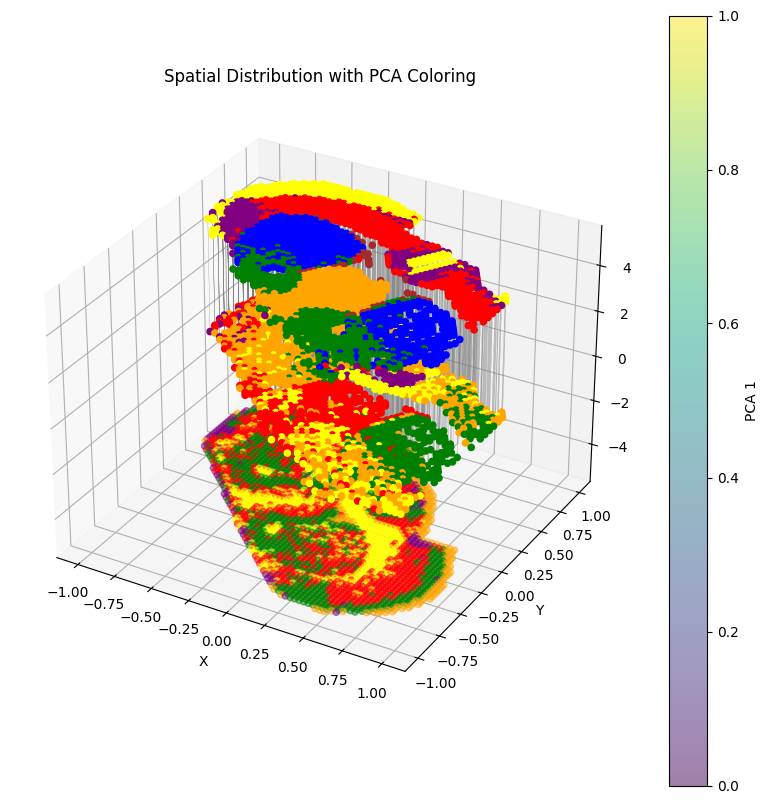

In [103]:
print(set(data1_leiden_str.astype(int)))
print(set(data2_leiden_str.astype(int)))
print(set(result_df["Most_freq_metabolic_cluster"].tolist()))
data2_pca_results = adata2.obsm['spatial']
print(data2_leiden_str)
color_mapping = {
    0: 'blue',
    1: 'red',
    2: 'green',
    3: 'yellow',
    4: 'orange',
    5: 'purple',
    6: 'brown',
    7: 'pink',
    8: 'gray',
    9: 'cyan',
    10: 'magenta',
    11: 'magenta'
}

a2_pca_results = adata2.obsm['spatial']  # PCA 结果
pca_leiden = adata2.obs["leiden"]
data2_leiden_str = pca_leiden.to_numpy()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
plt.scatter(data2_spatial_results.iloc[:, 0], data2_spatial_results.iloc[:, 1], zs=5,c=[color_mapping[category] for category in data2_leiden_str.astype(int)], s=20, alpha=1)
plt.scatter(data2_spatial_results.iloc[result_df[result_df["Simpson_Index"]<1.1]["spatial_ID"].tolist(), 0],data2_spatial_results.iloc[result_df[result_df["Simpson_Index"]<1.1]["spatial_ID"].tolist(), 1], zs=0,
            c=[color_mapping[category] for category in result_df[result_df["Simpson_Index"]<1]["Most_freq_metabolic_cluster"].tolist()], s=20, alpha=1)
plt.scatter(data3_spatial_results.iloc[:, 0], data3_spatial_results.iloc[:, 1], c=[color_mapping[category] for category in data1_leiden_str.astype(int)], s=20, alpha=0.5,zs=-5)
for i in result_df["spatial_ID"].tolist():
    plt.plot([data2_spatial_results.iloc[i, 0],data2_spatial_results.iloc[i, 0]],
            [data2_spatial_results.iloc[i, 1],data2_spatial_results.iloc[i, 1]],
             [0,5], 'gray', linewidth=0.2)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()